### Imports

In [1]:
import os

import numpy as np
import pandas as pd
from pathlib import Path

import torch
import pickle
import string
import itertools

import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from cdt.metrics import SHD

from simulation.simulation_tools import get_optimal_sim_XY, get_optimal_sim_XY_dual
from utils import custom_binary_metrics, _from_full_to_cp

rng = np.random.default_rng()

COL_NAMES = list(string.ascii_uppercase) + ["".join(a) for a in list(itertools.permutations(list(string.ascii_uppercase), r=2))]

Detecting 1 CUDA device(s).


TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


### Experiment 
Observe the behavior of TCS when given a dense graph in the 1st phase

In [ ]:
# data_path
ie_custom_path = list(Path(".").resolve().parents)[1] / "data" / "cp_style" / "increasing_edges_cp_1"


# placeholders
errors = []
scm_list = {}
shd_list = {}
scores_list = {}
det_auc_list = {}
struct_auc_list = {}

errors_w = []
scm_list_w = {}
shd_list_w = {}
scores_list_w = {}
det_auc_list_w = {}
struct_auc_list_w = {}


# run loop
for fn in os.listdir(ie_custom_path / "data"):
        print(f"\n\n------------------------------------- {fn} -------------------------------------")

        # read the time-series
        X_data = pd.read_csv(ie_custom_path / "data" / fn)
        X_data.rename(columns=dict(zip(X_data.columns, COL_NAMES[:X_data.shape[1]])), inplace=True)

        # read the ground truth
        gn = fn.split("_ts")[0] + "_struct.pt"
        Y_data = torch.load(ie_custom_path / "structure" / gn)
        # print(f"- edges : {Y_data.sum().int()}")

        # optimal simulation
        res, res_s = get_optimal_sim_XY_dual(
                true_data = X_data, 
                CONFIGS = None, 
                done_eval = False,
                optimal_det_config = None,
                optimal_det_func = None, 
                sparsity_penalty=True,
                verbose = True
        )

        # compare
        if isinstance(res["optimal_scm"], pd.DataFrame):
                pred_cp = _from_full_to_cp(res["optimal_scm"])
        else:
                pred_cp = res["optimal_scm"].causal_structure.causal_structure_cp
        true_cp = Y_data
        if  true_cp.shape[2]>pred_cp.shape[2]:
                pred_cp = torch.nn.functional.pad(input=pred_cp, pad=(0, true_cp.shape[2] - pred_cp.shape[2], 0, 0, 0, 0), value=0)
        if  pred_cp.shape[2]>true_cp.shape[2]:
                true_cp = torch.nn.functional.pad(input=true_cp, pad=(0, pred_cp.shape[2] - true_cp.shape[2], 0, 0, 0, 0), value=0)
        tpr, fpr, tnr, fnr, auc = custom_binary_metrics(binary=pred_cp, A=true_cp, verbose=True)
        shd_d = SHD(target=true_cp.numpy(), pred=pred_cp.numpy(), double_for_anticausal=True)

        # store
        scm_list[fn] =  pred_cp
        scores_list[fn] =  res["scores"]
        det_auc_list[fn] =  res["auc"]
        struct_auc_list[fn] =  {"tpr": tpr, "fpr": fpr, "tnr": tnr, "fnr": fnr, "auc": auc, "shd": shd_d,
                                "pred#": pred_cp.sum().numpy(), "true#": true_cp.sum().numpy()}
        shd_list[fn] = shd_d

        # ___________________________________________________________________________________________


        # compare
        if isinstance(res_s["optimal_scm"], pd.DataFrame):
                pred_cp = _from_full_to_cp(res_s["optimal_scm"])
        else:
                pred_cp = res_s["optimal_scm"].causal_structure.causal_structure_cp
        true_cp = Y_data
        if  true_cp.shape[2]>pred_cp.shape[2]:
                pred_cp = torch.nn.functional.pad(input=pred_cp, pad=(0, true_cp.shape[2] - pred_cp.shape[2], 0, 0, 0, 0), value=0)
        if  pred_cp.shape[2]>true_cp.shape[2]:
                true_cp = torch.nn.functional.pad(input=true_cp, pad=(0, pred_cp.shape[2] - true_cp.shape[2], 0, 0, 0, 0), value=0)
        tpr, fpr, tnr, fnr, auc = custom_binary_metrics(binary=pred_cp, A=true_cp, verbose=True)
        shd_d = SHD(target=true_cp.numpy(), pred=pred_cp.numpy(), double_for_anticausal=True)

        # store
        scm_list_w[fn] =  pred_cp
        scores_list_w[fn] =  res_s["scores"]
        det_auc_list_w[fn] =  res_s["auc"]
        struct_auc_list_w[fn] =  {"tpr": tpr, "fpr": fpr, "tnr": tnr, "fnr": fnr, "auc": auc, "shd": shd_d,
                                "pred#": pred_cp.sum().numpy(), "true#": true_cp.sum().numpy()}
        shd_list_w[fn] = shd_d



------------------------------------- (000)_cp_v10_l1_p95_ts.csv -------------------------------------
LOG: Optimal Simulation: 4 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1116.42it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:07<00:00, 139.18it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5318685890768272 (auc) || configs: 12 || elapsed_time: 5.21 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5357103874840823 (auc) || configs: 8 || elapsed_time: 9.93 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5314171366199745
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1173.21it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:07<00:00, 138.87it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.4926742566171879 (auc) || configs: 12 || elapsed_time: 5.16 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.517462398485014 (auc) || configs: 8 || elapsed_time: 8.87 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.540496740595069
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1199.35it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:07<00:00, 136.63it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5084121212121212 (auc) || configs: 12 || elapsed_time: 5.27 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.4948343079922026 (auc) || configs: 8 || elapsed_time: 8.94 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4918060606060606
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1100.62it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:07<00:00, 142.38it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5166530559959007 (auc) || configs: 12 || elapsed_time: 5.37 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5495705728101621 (auc) || configs: 8 || elapsed_time: 8.79 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5332836144056583
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=2 | auc=0.4918060606060606 | edges=6.0


100%|██████████| 100/100 [00:00<00:00, 469.49it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.5314171366199745 | edges=6.0


100%|██████████| 100/100 [00:00<00:00, 469.90it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.540496740595069 | edges=6.0


100%|██████████| 100/100 [00:00<00:00, 453.54it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.5332836144056583 | edges=6.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=2 | auc=0.4918060606060606 | edges=6.0
LOG: Optimal Simulation (0.4918060606060606 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": {
            "n_lags": 3,
            "n_reps": 10
        },
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
Total number of edges in the ground truth: 6
Total number of edges that were predicted: 6
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ________________________________

Total number of edges in the ground truth: 6
Total number of edges that were predicted: 6
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... _________________________

100%|██████████| 1000/1000 [00:00<00:00, 1253.08it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 119.09it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5705686475409837 (auc) || configs: 12 || elapsed_time: 5.47 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5531546947245787 (auc) || configs: 8 || elapsed_time: 9.07 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5706006659836066
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1185.43it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 113.04it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5177621884810045 (auc) || configs: 12 || elapsed_time: 5.5 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5423358461706544 (auc) || configs: 8 || elapsed_time: 9.19 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5468698787282859
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1117.32it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 119.63it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5305769230769231 (auc) || configs: 12 || elapsed_time: 5.71 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5360655737704919 (auc) || configs: 8 || elapsed_time: 9.01 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5322768670309654
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1186.32it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 117.29it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.589599358974359 (auc) || configs: 12 || elapsed_time: 5.49 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5434902780782079 (auc) || configs: 8 || elapsed_time: 9.06 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.589727564102564
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=2 | auc=0.5322768670309654 | edges=11.0


100%|██████████| 100/100 [00:00<00:00, 451.10it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.5706006659836066 | edges=12.0


100%|██████████| 100/100 [00:00<00:00, 361.61it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.5468698787282859 | edges=12.0


100%|██████████| 100/100 [00:00<00:00, 398.35it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.589727564102564 | edges=11.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=2 | auc=0.5322768670309654 | edges=11.0
LOG: Optimal Simulation (0.5322768670309654 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": {
            "n_lags": 3,
            "n_reps": 10
        },
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
Total number of edges in the ground truth: 11
Total number of edges that were predicted: 11
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ________________________________

Total number of edges in the ground truth: 11
Total number of edges that were predicted: 11
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ____________________

100%|██████████| 1000/1000 [00:01<00:00, 690.99it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 104.04it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5648232821549469 (auc) || configs: 12 || elapsed_time: 6.53 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5403288201160541 (auc) || configs: 8 || elapsed_time: 9.75 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5598017038070944
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 752.45it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 105.09it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5313045008720141 (auc) || configs: 12 || elapsed_time: 6.1 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5189511380296584 (auc) || configs: 8 || elapsed_time: 9.43 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5288564617033873
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 876.56it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 121.94it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.538648618377894 (auc) || configs: 12 || elapsed_time: 5.49 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5541190041334232 (auc) || configs: 8 || elapsed_time: 9.48 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5505022589637605
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 832.15it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 119.31it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5695931134898159 (auc) || configs: 12 || elapsed_time: 5.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5063650250963847 (auc) || configs: 8 || elapsed_time: 9.33 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5686890990255845
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=1 | auc=0.5288564617033873 | edges=11.0


100%|██████████| 100/100 [00:00<00:00, 420.16it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.5598017038070944 | edges=11.0


100%|██████████| 100/100 [00:00<00:00, 390.63it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.5505022589637605 | edges=12.0


100%|██████████| 100/100 [00:00<00:00, 411.52it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.5686890990255845 | edges=12.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=1 | auc=0.5288564617033873 | edges=11.0
LOG: Optimal Simulation (0.5288564617033873 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "spline"
    },
    "z": {
        "noise_approximation": "spline"
    }
}
Total number of edges in the ground truth: 11
Total number of edges that were predicted: 11
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ________________________________

Total number of edges in the ground truth: 11
Total number of edges that were predicted: 11
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ________________________________



----------------------------------

100%|██████████| 1000/1000 [00:01<00:00, 845.64it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 119.78it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5777649769585254 (auc) || configs: 12 || elapsed_time: 5.36 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5990396158463386 (auc) || configs: 8 || elapsed_time: 9.59 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5661719233147806
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 841.22it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 120.33it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5546915002560163 (auc) || configs: 12 || elapsed_time: 5.51 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5785844250363901 (auc) || configs: 8 || elapsed_time: 9.79 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5740720524017467
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 814.19it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 118.05it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6353306446450291 (auc) || configs: 12 || elapsed_time: 5.39 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5511390944919734 (auc) || configs: 8 || elapsed_time: 9.48 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6355066897125664
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 869.09it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 117.75it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6197296298082333 (auc) || configs: 12 || elapsed_time: 5.69 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5593568665377177 (auc) || configs: 8 || elapsed_time: 9.43 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6197778527913069
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=0 | auc=0.5661719233147806 | edges=13.0


100%|██████████| 100/100 [00:00<00:00, 471.70it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.5740720524017467 | edges=13.0


100%|██████████| 100/100 [00:00<00:00, 471.47it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.6355066897125664 | edges=13.0


100%|██████████| 100/100 [00:00<00:00, 394.42it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.6197778527913069 | edges=13.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=0 | auc=0.5661719233147806 | edges=13.0
LOG: Optimal Simulation (0.5661719233147806 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
Total number of edges in the ground truth: 13
Total number of edges that were predicted: 13
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ________________________________

Total number of edges in the ground truth: 13
Total number of edges that were predicted: 13
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ________________________________



------------------------------------- (0

100%|██████████| 1000/1000 [00:01<00:00, 892.32it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 111.65it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5362785114045617 (auc) || configs: 12 || elapsed_time: 5.49 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5182372203019829 (auc) || configs: 8 || elapsed_time: 9.29 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5266586634653861
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 879.88it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 110.91it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5562168570467325 (auc) || configs: 12 || elapsed_time: 5.4 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5404382325107375 (auc) || configs: 8 || elapsed_time: 9.47 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5562168570467325
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 745.16it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 110.95it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5962345441732335 (auc) || configs: 12 || elapsed_time: 5.41 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5740089167369563 (auc) || configs: 8 || elapsed_time: 9.4 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.59544173233391
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 867.53it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:08<00:00, 114.04it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5438707070707071 (auc) || configs: 12 || elapsed_time: 5.48 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5246879166161678 (auc) || configs: 8 || elapsed_time: 9.36 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5447515151515151
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=0 | auc=0.5266586634653861 | edges=14.0


100%|██████████| 100/100 [00:00<00:00, 387.55it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.5562168570467325 | edges=14.0


100%|██████████| 100/100 [00:00<00:00, 453.06it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.59544173233391 | edges=14.0


100%|██████████| 100/100 [00:00<00:00, 459.76it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.5447515151515151 | edges=14.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=0 | auc=0.5266586634653861 | edges=14.0
LOG: Optimal Simulation (0.5266586634653861 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
Total number of edges in the ground truth: 13
Total number of edges that were predicted: 14
AUC: 0.9942528605461121
TPR: 1.0, FPR: 0.01149425283074379, TNR: 0.9885057210922241, FNR: 0.0
__________________________________ ... ________________________________

Total number of edges in the ground truth: 13
Total number of edges that were predicted: 14
AUC: 0.9942528605461121
TPR: 1.0, FPR: 0.01149425283074379, TNR: 0.9885057210922241, FNR: 0.0
_______________________

100%|██████████| 1000/1000 [00:01<00:00, 885.66it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 107.86it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5838950950179764 (auc) || configs: 12 || elapsed_time: 5.29 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5596164383561644 (auc) || configs: 8 || elapsed_time: 9.27 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5828197226502312
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 842.59it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 109.34it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5142596065983744 (auc) || configs: 12 || elapsed_time: 5.65 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.55953985367732 (auc) || configs: 8 || elapsed_time: 9.33 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5582643434732384
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 842.93it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 104.73it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6111751152073732 (auc) || configs: 12 || elapsed_time: 5.44 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5400678422787307 (auc) || configs: 8 || elapsed_time: 9.29 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6114951356886841
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 859.49it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 103.95it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6457049306625577 (auc) || configs: 12 || elapsed_time: 5.17 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5345753424657534 (auc) || configs: 8 || elapsed_time: 10.21 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6458413585002567
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=1 | auc=0.5582643434732384 | edges=19.0


100%|██████████| 100/100 [00:00<00:00, 434.78it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.5828197226502312 | edges=19.0


100%|██████████| 100/100 [00:00<00:00, 427.36it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.6114951356886841 | edges=20.0


100%|██████████| 100/100 [00:00<00:00, 340.53it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=1 | auc=0.5582643434732384 | edges=19.0
LOG: Optimal Simulation (0.5582643434732384 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "spline"
    },
    "z": {
        "noise_approximation": "spline"
    }
}
Total number of edges in the ground truth: 18
Total number of edges that were predicted: 19
AUC: 0.9939024448394775
TPR: 1.0, FPR: 0.012195121496915817, TNR: 0.9878048896789551, FNR: 0.0
__________________________________ ... ________________________________

Total number of edges in the ground truth: 18
Total number of edges that were predicted: 19
AUC: 0.9939024448394775
TPR: 1.0, FPR: 0.012195121496915817, TNR: 0.9878048896789551, FNR: 0.0
__________________________________ ... ________________________________



------------------------------------- 

100%|██████████| 1000/1000 [00:01<00:00, 907.70it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 110.25it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5204791840400282 (auc) || configs: 12 || elapsed_time: 5.92 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.522971099109619 (auc) || configs: 8 || elapsed_time: 8.87 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5193584878119982
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 870.95it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 105.11it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5835681352459017 (auc) || configs: 12 || elapsed_time: 5.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5284961628214689 (auc) || configs: 8 || elapsed_time: 8.87 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5834480660860656
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 880.91it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 109.27it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7010211769986694 (auc) || configs: 12 || elapsed_time: 5.12 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5352112676056338 (auc) || configs: 8 || elapsed_time: 8.83 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.7010211769986694
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 872.55it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 108.32it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6749951996927803 (auc) || configs: 12 || elapsed_time: 5.25 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.48818348093954567 (auc) || configs: 8 || elapsed_time: 8.83 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6751472094214029
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=0 | auc=0.5193584878119982 | edges=23.0


100%|██████████| 100/100 [00:00<00:00, 490.18it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.5834480660860656 | edges=23.0


100%|██████████| 100/100 [00:00<00:00, 397.70it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=0 | auc=0.5193584878119982 | edges=23.0
LOG: Optimal Simulation (0.5193584878119982 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
Total number of edges in the ground truth: 22
Total number of edges that were predicted: 23
AUC: 0.9935896992683411
TPR: 1.0, FPR: 0.012820512987673283, TNR: 0.9871794581413269, FNR: 0.0
__________________________________ ... ________________________________

Total number of edges in the ground truth: 22
Total number of edges that were predicted: 23
AUC: 0.9935896992683411
TPR: 1.0, FPR: 0.012820512987673283, TNR: 0.9871794581413269, FNR: 0.0
__________________________________ ... ________________________________



------------------------------------- (007)_

100%|██████████| 1000/1000 [00:01<00:00, 879.69it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 108.73it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5747115384615384 (auc) || configs: 12 || elapsed_time: 5.29 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5268876007145722 (auc) || configs: 8 || elapsed_time: 8.7 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5742307692307692
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 895.48it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 111.50it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5489161757172132 (auc) || configs: 12 || elapsed_time: 5.46 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5088942307692308 (auc) || configs: 8 || elapsed_time: 8.7 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4488185194672132
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 903.87it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 110.66it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7278493177013261 (auc) || configs: 12 || elapsed_time: 4.98 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5012259615384616 (auc) || configs: 8 || elapsed_time: 9.13 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.7277852520981485
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 916.35it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:09<00:00, 110.77it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7263918252290346 (auc) || configs: 12 || elapsed_time: 5.3 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5419137711478988 (auc) || configs: 8 || elapsed_time: 9.03 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.726367800627843
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=1 | auc=0.4488185194672132 | edges=20.0


100%|██████████| 100/100 [00:00<00:00, 378.51it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=1 | auc=0.4488185194672132 | edges=20.0
LOG: Optimal Simulation (0.4488185194672132 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "spline"
    },
    "z": {
        "noise_approximation": "spline"
    }
}
Total number of edges in the ground truth: 20
Total number of edges that were predicted: 20
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ________________________________

Total number of edges in the ground truth: 20
Total number of edges that were predicted: 20
AUC: 1.0
TPR: 1.0, FPR: 0.0, TNR: 1.0, FNR: 0.0
__________________________________ ... ________________________________



------------------------------------- (008)_cp_v10_l1_p71_ts.csv -------------------------------------
LOG: Optimal Simulation: 4 TC

 99%|█████████▉| 988/1000 [00:01<00:00, 810.93it/s]


LOG: Optimal Simulation: A configuration failed to run, thus is removed : 4 -> 3
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 3, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


 44%|████▍     | 444/1000 [00:00<00:00, 849.96it/s]

### Store Results

In [ ]:
# merge
res_both = {
    "res" : struct_auc_list,
    "res_w" : struct_auc_list_w, 
}

# # store results
# pickle.dump(res_both, open(list(Path(".").resolve().parents)[1] / "data" / "results" / "dense_graph" / "res_cp_vs_1.p", "wb"))

### Plot

#### Oracle Plot

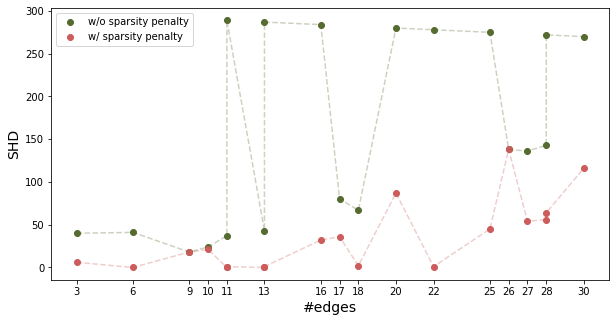

In [2]:
# load data
res_both = pickle.load(open(list(Path(".").resolve().parents)[1] / "data" / "results" / "dense_graph" / "res_cp_vs_1.p", "rb"))

# sort results according to ground truth edge density
sorted_true, sorted_shd = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_both['res'].values())], 
    [v["shd"] for v in list(res_both['res'].values())])), key=lambda x: x[0])[:])) 

sorted_true_w, sorted_shd_w = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_both['res_w'].values())], 
    [v["shd"] for v in list(res_both['res_w'].values())])), key=lambda x: x[0])[:])) 

# plot
f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x=sorted_true, y=sorted_shd, label="w/o sparsity penalty", color="darkolivegreen")
ax.plot(sorted_true, sorted_shd, "--", color="darkolivegreen", alpha=0.3)
ax.scatter(x=sorted_true_w, y=sorted_shd_w, label="w/ sparsity penalty", color='indianred')
ax.plot(sorted_true_w, sorted_shd_w, "--", color='indianred', alpha=0.3)
ax.set_xticks(list(set([int(x) for x in sorted_true])))
ax.set_xticklabels(list(set([int(x) for x in sorted_true])))
ax.set_xlabel("#edges", fontsize=14)
ax.set_ylabel("SHD", fontsize=14)
# ax.set_title("SHD on synthetic data w/ increasing # of edges.")
ax.legend()
plt.show()

#### Submission Plots

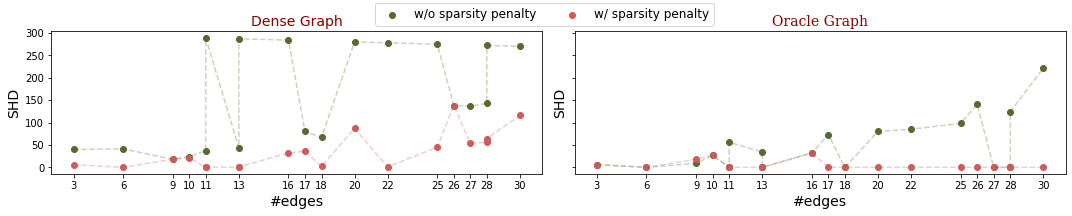

In [3]:
# double figure for the submission

# load data
res_dense = pickle.load(open(list(Path(".").resolve().parents)[1] / "data" / "results" / "dense_graph" / "res_cp_vs_1.p", "rb"))
res_oracle = pickle.load(open(list(Path(".").resolve().parents)[1] / "data" / "results" / "oracle_graph" / "res_cp_vs_1.p", "rb"))

# sort results according to ground truth edge density - dense
sorted_true_dense, sorted_shd_dense = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_dense['res'].values())], 
    [v["shd"] for v in list(res_dense['res'].values())])), key=lambda x: x[0])[:])) 

sorted_true_w_dense, sorted_shd_w_dense = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_dense['res_w'].values())], 
    [v["shd"] for v in list(res_dense['res_w'].values())])), key=lambda x: x[0])[:])) 

# sort results according to ground truth edge density - oracle
sorted_true_oracle, sorted_shd_oracle = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_oracle['res'].values())], 
    [v["shd"] for v in list(res_oracle['res'].values())])), key=lambda x: x[0])[:])) 

sorted_true_w_oracle, sorted_shd_w_oracle = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_oracle['res_w'].values())], 
    [v["shd"] for v in list(res_oracle['res_w'].values())])), key=lambda x: x[0])[:]))

# plot
f, axs = plt.subplots(ncols=2, figsize=(15, 3), sharey=True)

axs[0].scatter(x=sorted_true_dense, y=sorted_shd_dense, label="w/o sparsity penalty", color="darkolivegreen")
axs[0].plot(sorted_true_dense, sorted_shd_dense, "--", color="darkolivegreen", alpha=0.3)
axs[0].scatter(x=sorted_true_w_dense, y=sorted_shd_w_dense, label="w/ sparsity penalty", color='indianred')
axs[0].plot(sorted_true_w_dense, sorted_shd_w_dense, "--", color='indianred', alpha=0.3)
axs[0].set_xticks(list(set([int(x) for x in sorted_true_dense])))
axs[0].set_xticklabels(list(set([int(x) for x in sorted_true_dense])))
axs[0].set_xlabel("#edges", fontsize=14)
axs[0].set_ylabel("SHD", fontsize=14)
axs[0].set_title("Dense Graph", fontdict={"size": 14, "color": "darkred"})

f.legend(loc=(0.35, 0.88), ncol=4, fontsize=12)

axs[1].scatter(x=sorted_true_oracle, y=sorted_shd_oracle, label="w/o sparsity penalty", color="darkolivegreen")
axs[1].plot(sorted_true_oracle, sorted_shd_oracle, "--", color="darkolivegreen", alpha=0.3)
axs[1].scatter(x=sorted_true_w_oracle, y=sorted_shd_w_oracle, label="w/ sparsity penalty", color='indianred')
axs[1].plot(sorted_true_w_oracle, sorted_shd_w_oracle, "--", color='indianred', alpha=0.3)
axs[1].set_xticks(list(set([int(x) for x in sorted_true_oracle])))
axs[1].set_xticklabels(list(set([int(x) for x in sorted_true_oracle])))
axs[1].set_xlabel("#edges", fontsize=14)
axs[1].set_ylabel("SHD", fontsize=14)
axs[1].set_title("Oracle Graph", fontdict={"size": 14, "color": "darkred", 'family': 'serif'})

plt.tight_layout()
plt.show()

#### Submission Tables

In [4]:
import json

# load data
res_auc = json.load(open(list(Path(".").resolve().parents)[1] / "data" / "results" / "vs" / "cp_1_auc.json", "r"))
res_mmd = json.load(open(list(Path(".").resolve().parents)[1] / "data" / "results" / "vs" / "cp_1_mmd.json", "r"))

auc_mean_tcs = np.array([x["tcs"] for x in res_auc.values()]).mean().round(2)
mmd_mean_tcs = np.array([x["tcs"] for x in res_mmd.values()]).mean().round(2)
auc_var_tcs = np.array([x["tcs"] for x in res_auc.values()]).var().round(2)
mmd_var_tcs = np.array([x["tcs"] for x in res_mmd.values()]).var().round(2)

auc_mean_ct = np.array([x["ct"] for x in res_auc.values()]).mean().round(2)
mmd_mean_ct = np.array([x["ct"] for x in res_mmd.values()]).mean().round(2)
auc_var_ct = np.array([x["ct"] for x in res_auc.values()]).var().round(2)
mmd_var_ct = np.array([x["ct"] for x in res_mmd.values()]).var().round(2)

auc_mean_cpar = np.array([x["cpar"] for x in res_auc.values()]).mean().round(2)
mmd_mean_cpar = np.array([x["cpar"] for x in res_mmd.values()]).mean().round(2)
auc_var_cpar = np.array([x["cpar"] for x in res_auc.values()]).var().round(2)
mmd_var_cpar = np.array([x["cpar"] for x in res_mmd.values()]).var().round(2)

auc_mean_tvae = np.array([x["tvae"] for x in res_auc.values()]).mean().round(2)
mmd_mean_tvae = np.array([x["tvae"] for x in res_mmd.values()]).mean().round(2)
auc_var_tvae = np.array([x["tvae"] for x in res_auc.values()]).var().round(2)
mmd_var_tvae = np.array([x["tvae"] for x in res_mmd.values()]).var().round(2)

print("TCS")
print(f"- mmd : {mmd_mean_tcs} +- {mmd_var_tcs}")
print(f"- auc : {auc_mean_tcs} +- {auc_var_tcs}")
print("CT")
print(f"- mmd : {mmd_mean_ct} +- {mmd_var_ct}")
print(f"- auc : {auc_mean_ct} +- {auc_var_ct}")
print("CPAR")
print(f"- mmd : {mmd_mean_cpar} +- {mmd_var_cpar}")
print(f"- auc : {auc_mean_cpar} +- {auc_var_cpar}")
print("TVAE")
print(f"- mmd : {mmd_mean_tvae} +- {mmd_var_tvae}")
print(f"- auc : {auc_mean_tvae} +- {auc_var_tvae}")

TCS
- mmd : 0.09 +- 0.11
- auc : 0.57 +- 0.0
CT
- mmd : 0.9 +- 0.02
- auc : 0.77 +- 0.0
CPAR
- mmd : 0.04 +- 0.01
- auc : 0.63 +- 0.01
TVAE
- mmd : 0.11 +- 0.0
- auc : 0.81 +- 0.0
